# Efficient Data Preparation and Exploratory Analysis for Job Change Prediction
This notebook demonstrates advanced data cleaning, feature engineering, and exploratory analysis for predicting student job change intentions.

![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

You've been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

You've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so you can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

In [124]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ds_jobs = pd.read_csv("customer_train.csv")

# View the dataset
ds_jobs.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Workflow
- Handle missing values with context-appropriate replacements
- Convert columns to efficient types (category, bool, int32, float16)
- Engineer features (ordered categoricals, binary conversion)
- Visualize distributions and relationships using Seaborn and Matplotlib
- Filter and analyze data using business logic
- Inspect and validate the final dataset

In [125]:
# --- Create a copy of the original dataframe to work on ---
ds_jobs_transformed = ds_jobs.copy()

# --- Handle missing values ---
fillna_dict = {
    'gender': 'Other',
    'major_discipline': 'No Major',
    'company_type': 'Other',
    'education_level': 'Primary School',
    'enrolled_university': 'no_enrollment',
    'experience': '<1',
    'company_size': '<10',
    'last_new_job': 'never',
    'relevant_experience': 'No relevant experience'
}
ds_jobs_transformed = ds_jobs_transformed.fillna(value=fillna_dict)

# --- Convert object columns to category ---
for col in ds_jobs_transformed:
    if ds_jobs_transformed[col].dtype.name == "object":
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype("category")

# --- Feature Engineering: Convert binary columns to boolean ---
ds_jobs_transformed["relevant_experience"] = ds_jobs_transformed["relevant_experience"].map({"No relevant experience": False, "Has relevant experience": True}).astype("bool")
ds_jobs_transformed["job_change"] = ds_jobs_transformed["job_change"].map({0: False, 1: True}).astype("bool")

# --- Convert nominal columns to category dtype ---
nominal_cats_list = ["gender", "major_discipline", "company_type"]
ds_jobs_transformed[nominal_cats_list] = ds_jobs_transformed[nominal_cats_list].astype("category")

# --- Reorder categories for ordinal columns ---
ds_jobs_transformed["enrolled_university"] = ds_jobs_transformed["enrolled_university"].cat.reorder_categories([
    "no_enrollment", "Part time course", "Full time course"
], ordered=True)
ds_jobs_transformed["education_level"] = ds_jobs_transformed["education_level"].cat.reorder_categories([
    "Primary School", "High School", "Graduate", "Masters", "Phd"
], ordered=True)
ds_jobs_transformed["company_size"] = ds_jobs_transformed["company_size"].cat.reorder_categories([
    "<10", "10-49", "50-99", "100-499", "500-999", "1000-4999", "5000-9999", "10000+"
], ordered=True)
ds_jobs_transformed["last_new_job"] = ds_jobs_transformed["last_new_job"].cat.reorder_categories([
    "never", "1", "2", "3", "4", ">4"
], ordered=True)
ds_jobs_transformed["experience"] = ds_jobs_transformed["experience"].cat.reorder_categories([
    "<1", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", ">20"
], ordered=True)

# --- Optimize numeric types ---
for col in ds_jobs_transformed:
    if ds_jobs_transformed[col].dtype.name == "int64":
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype("int32")
    if ds_jobs_transformed[col].dtype.name == "float64":
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype("float16")


# --- Inspect final dataframe ---
ds_jobs_transformed.dtypes

student_id                   int32
city                      category
city_development_index     float16
gender                    category
relevant_experience           bool
enrolled_university       category
education_level           category
major_discipline          category
experience                category
company_size              category
company_type              category
last_new_job              category
training_hours               int32
job_change                    bool
dtype: object

## Visualizations

- Count plots for categorical features show the distribution of each category.
- Bar plots compare training hours by education level.
- Bar plots analyze job change rates by company size, experience, gender, and major discipline.

These visualizations help identify patterns and relationships relevant to predicting job change intentions.

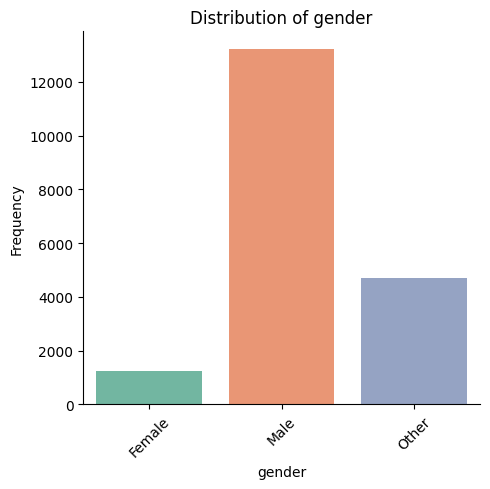

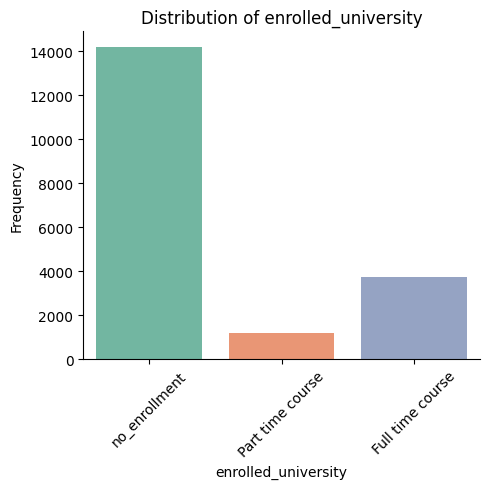

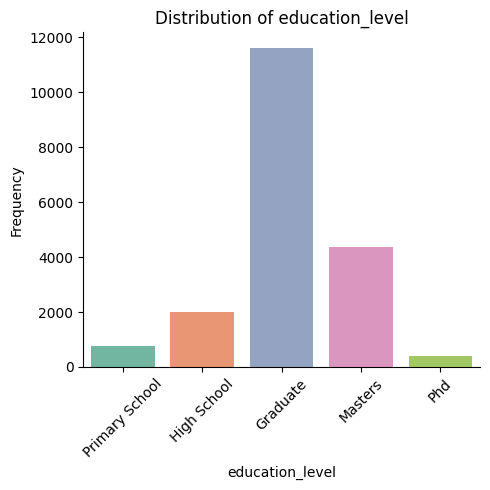

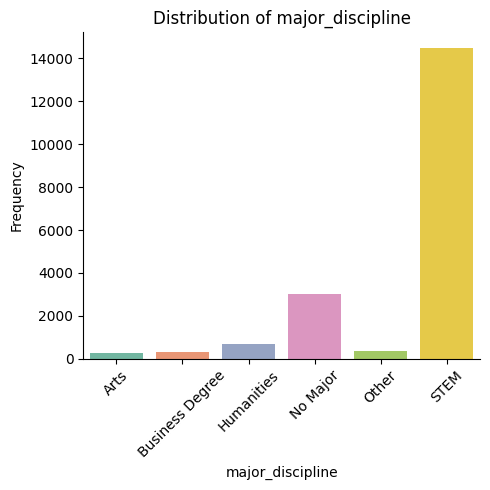

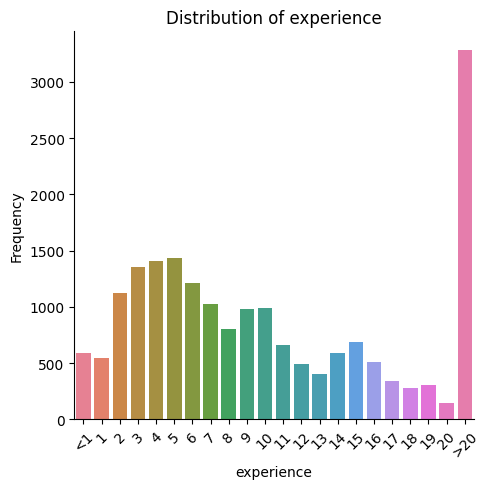

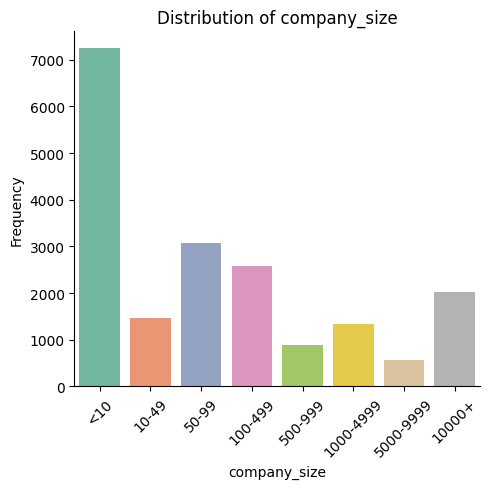

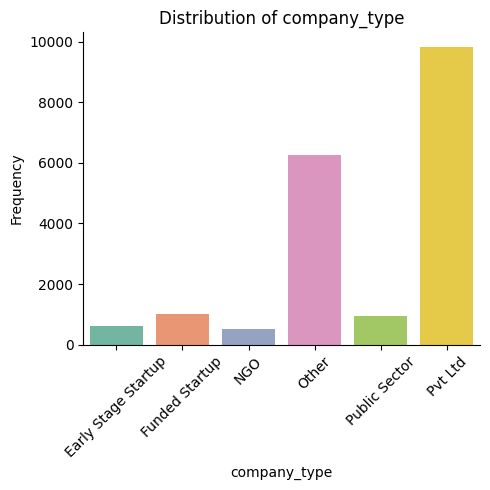

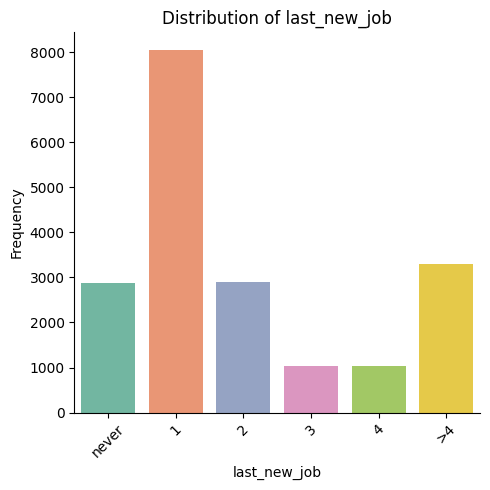

In [126]:
sns.set_palette("Set2")
def cat_vis (df , col):
    sns.catplot(kind = "count",x=col, data=df, hue = col)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"plots/{col}_distribution.png")
    plt.show()

for col in ds_jobs_transformed.select_dtypes(include=['category']).columns:
    if col != "city":
        cat_vis(ds_jobs_transformed, col)

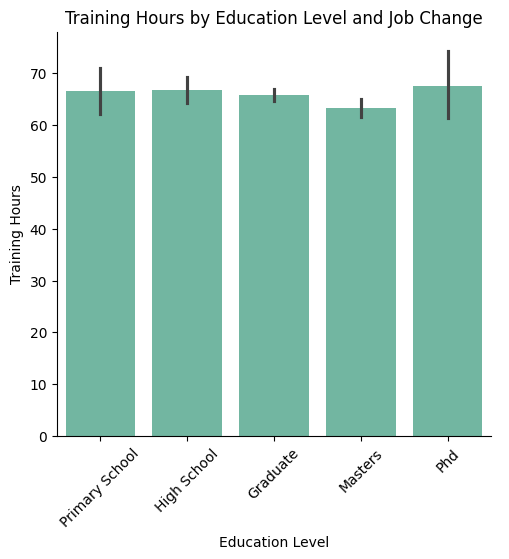

In [127]:
sns.catplot(kind = "bar", x = "education_level", y = "training_hours", data = ds_jobs_transformed)
plt.title("Training Hours by Education Level and Job Change")
plt.xlabel("Education Level")
plt.ylabel("Training Hours")
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

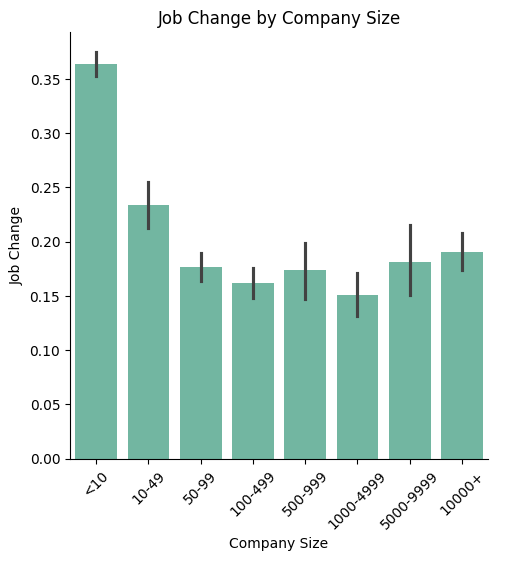

In [128]:
# `company_size` vs. `job_change`:
sns.catplot(kind="bar", x="company_size", y="job_change", data=ds_jobs_transformed)
plt.xlabel("Company Size")
plt.ylabel("Job Change")
plt.title("Job Change by Company Size")
plt.xticks(rotation=45)
plt.show()

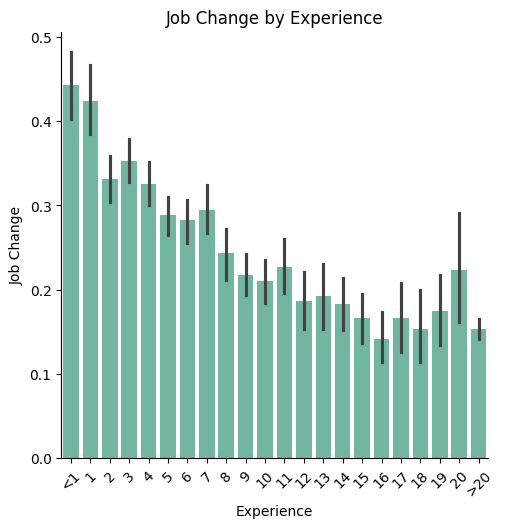

In [129]:
# `experience` vs. `job_change`:
sns.catplot(kind="bar", x="experience", y="job_change", data=ds_jobs_transformed)
plt.xlabel("Experience")
plt.ylabel("Job Change")
plt.title("Job Change by Experience")
plt.xticks(rotation=45)
plt.show()

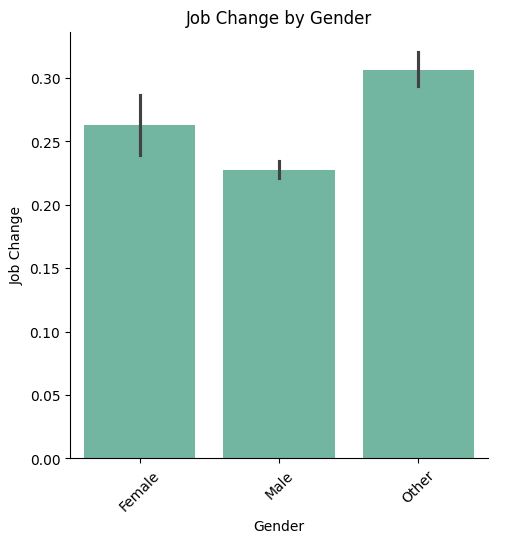

In [130]:
#`gender` vs. `job_change`:
sns.catplot(kind="bar", x="gender", y="job_change", data=ds_jobs_transformed)
plt.xlabel("Gender")
plt.ylabel("Job Change")
plt.title("Job Change by Gender")
plt.xticks(rotation=45)
plt.show()

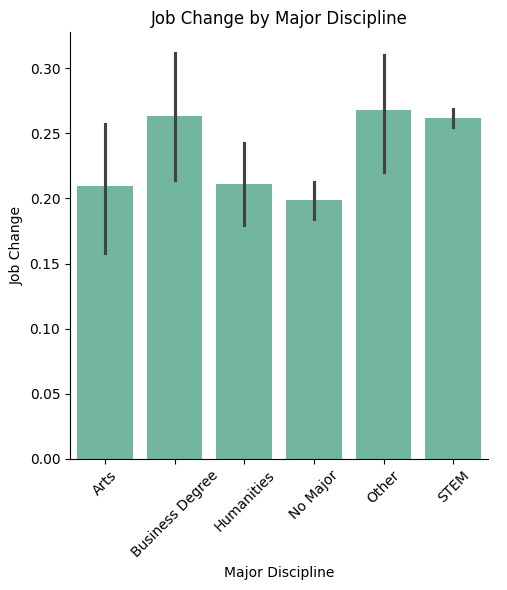

In [131]:
# `major_discipline` vs. `job_change`
sns.catplot(kind="bar", x="major_discipline", y="job_change", data=ds_jobs_transformed)
plt.xlabel("Major Discipline")
plt.ylabel("Job Change")
plt.title("Job Change by Major Discipline")
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

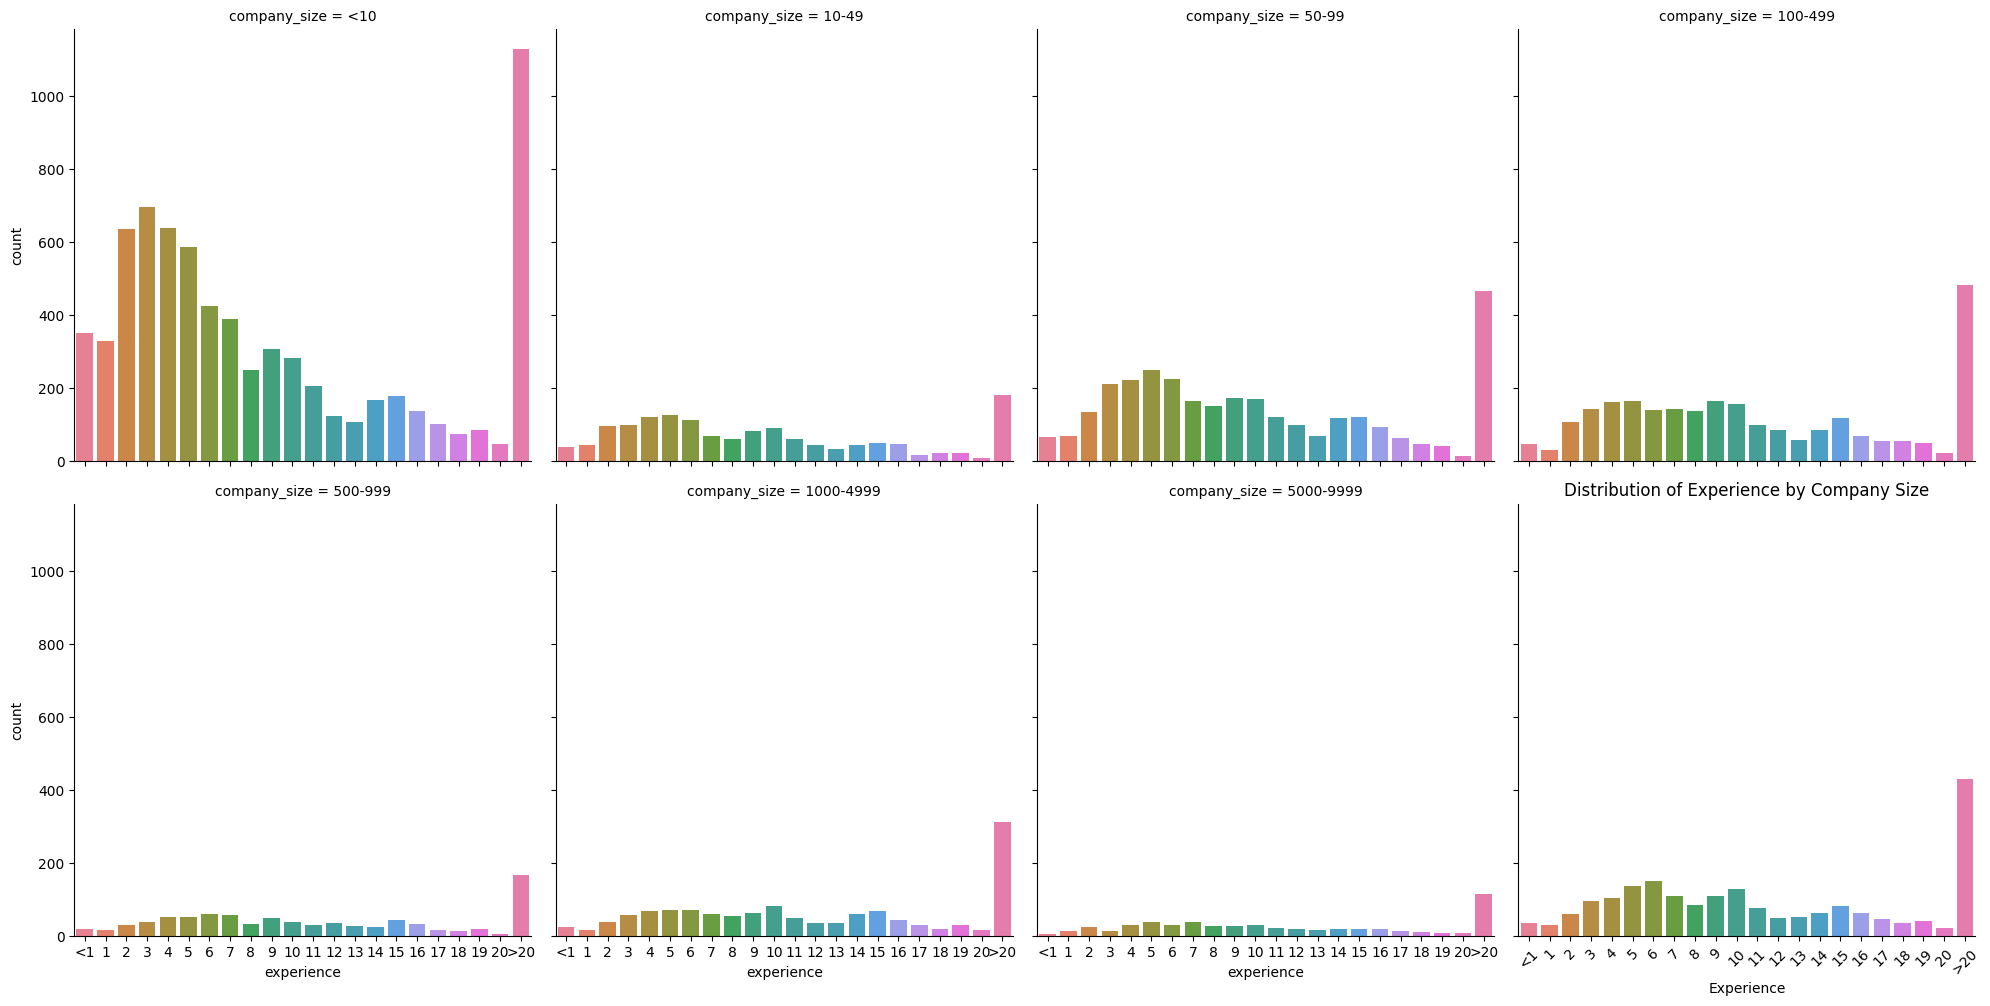

In [182]:
plt.figure(figsize=(10,6))
sns.catplot(kind = 'count', x='experience', data=ds_jobs_transformed, hue="experience",col='company_size', 
            col_wrap=4)
plt.xticks(rotation=45)
plt.title('Distribution of Experience by Company Size')
plt.xlabel('Experience')
plt.ylabel('Count')
plt.savefig('plots/experience_by_company_size.png')
plt.show()

## Core Concepts & Portfolio Readiness
- Data cleaning, type optimization, and feature engineering
- Data transformation and visualization
- Filtering, selection, and exploratory analysis
This notebook is ready for portfolio presentation and further modeling if desired.